In [1]:
# This script generates MOOSE inputs files to simulate a large soil column under a tidal strain,
# compute the change in water content and plot figure 5.

# For this simulation we studied discrete values of specific storage (S_{\epsilon}) and bulk modulus (K)
# and continuous values of hydrauluc conductivity of the soil column (k_l). We start with a base simulation
# that contains the geometry, physics to solve, time stepper and basic material properties. This script modifiy
# the material properties of the base file.

# First, open a MOOSE input "base file" with a pre-set simulation

# path to the base file (this may change depending on your set up)
# path to base file

Generate three input files for the three specific storages and bulk modulus under study.

In [2]:
import numpy as np

# Specific storage discrete values. Remember that S_{\epsilon} = porosity / K_f. Hence, we vary porosity
# since K_f = constant = 2E9
porosity = np.array((0.02, 0.2, 2))

# The bulk modulus
bulk = np.array((1E9, 10E9, 100E9))
compressibility = 1/bulk 
exp = np.array((9,10,11))

# The hydraulic conductivity values
P_LE = np.logspace(-7,-4, 50) * 1E-7

path = # your path to this script
sim_files = 'sim_files/'
foulders_n = ['n_0.02/', 'n_0.2/', 'n_2/']
foulders_K = ['bulk_9/', 'bulk_10/', 'bulk_11/']

for k, n in enumerate(porosity):

    # First, open a MOOSE input "base file" with a pre-set simulation
    with open(path + 'base_file.i', 'r') as file:
            filedata = file.read()

    # Replace the target string porosity
    filedata_n = filedata.replace('    porosity = .02','     porosity = ' + str(n))
    
    for l, i in enumerate(bulk):

        # Replace the target string bulk modulus
        filedata_K = filedata_n.replace('    bulk_modulus = 1E11','    bulk_modulus = ' + str(i))
        # Replace the target string compressibility
        filedata_K = filedata_K.replace('    solid_bulk_compliance = 1E-11','    bulk_modulus = ' + str(compressibility[l]))
        
        for t, m in enumerate(P_LE):
        
            # Replace the target string permeability
            filedata_k = filedata_K.replace('1E-12 0 0   0 1E-12 0   0 0 1E-12', str(m) + ' 0 0 0 ' + str(m) + ' 0 0 0 1E-150')
            # Write the file out again
            with open(path + sim_files + foulders_n[k] + foulders_K[l] + 'n_' + str(n) + '_bulk_' + str(exp[l]) + '_cond_'  + str(t) + '.i', 'w') as file:
                file.write(filedata_k)
        
    

Perform simulations! We suggest to generate a python script to write the simulations automatically in the console. We dont include results of simulations here to minimize the size of this files. But we include the stacked results.

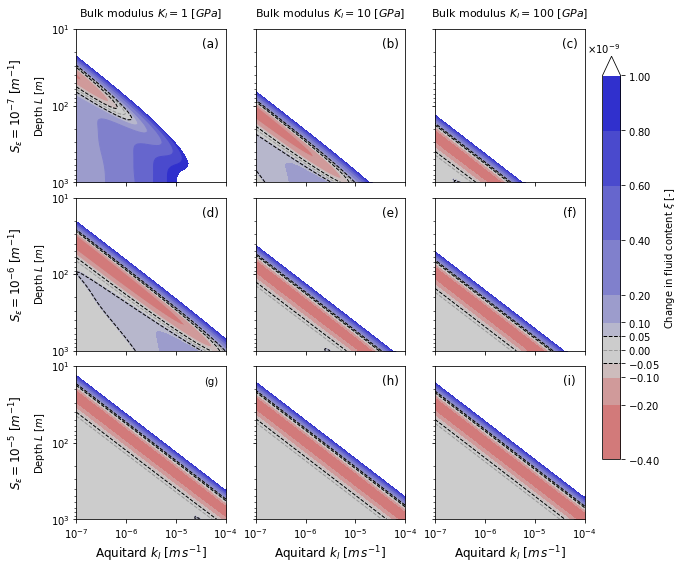

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.colors as colors

#%% create a colormap
grey = [0.8,0.8,0.8]
white = [1, 1, 1]
blue = [0, 0, 205/255]
red = [(220/255), 0, 0]
black= [0, 0, 0]

reds = LinearSegmentedColormap.from_list("reds", [grey, red], N=256)
blues = LinearSegmentedColormap.from_list("reds", [grey, blue], N=256)

cmap = LinearSegmentedColormap.from_list('mycmap', 
    [(0, reds(0.4/0.999)), 
      (0.35/1.4, grey), 
      (0.35/1.4, grey),
      (0.45/1.4, grey),
      (0.45/1.4, grey), 
      (1, blues(0.9))])
cmap.set_over('w')

# Levels to plot
levels = np.array([-4E-10, -2E-10, -1E-10, -0.5e-10, 0.5e-10, 1E-10, 2E-10, 4E-10, 6E-10, 8E-10, 10E-10])
norm = BoundaryNorm(levels, cmap.N, clip=False, extend='max')

## Read data 
res = path + 'stk_res/'
S7_K9 =  np.genfromtxt(res + 'S7_K9.csv', delimiter=',')
S7_K10 =  np.genfromtxt(res + 'S7_K10.csv', delimiter=',')
S7_K11 =  np.genfromtxt(res + 'S7_K11.csv', delimiter=',')
S6_K9 =  np.genfromtxt(res + 'S6_K9.csv', delimiter=',')
S6_K10 =  np.genfromtxt(res + 'S6_K10.csv', delimiter=',')
S6_K11 =  np.genfromtxt(res + 'S6_K11.csv', delimiter=',')
S5_K9 =  np.genfromtxt(res + 'S5_K9.csv', delimiter=',')
S5_K10 =  np.genfromtxt(res + 'S5_K10.csv', delimiter=',')
S5_K11 =  np.genfromtxt(res + 'S5_K11.csv', delimiter=',')

# Make the plot
fig, axs = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)

# Grid
X = np.logspace(-7,-4,50)
Y = np.linspace(0,1000,1000)
# Y = np.logspace(3,1,1000)

# Font of the figure
font = 12

# Figure (a)
ax = axs[0,0]

# S7_K9.T[S7_K9.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S7_K9.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S7_K9.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S7_K9.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9,'(a)', ha='center', va='center', color='k', transform=ax.transAxes,fontsize=font)
ax.text(0.5, 1.1, r'Bulk modulus $K_l = 1$ [$GPa$]', ha='center', va='center', color='k', transform=ax.transAxes,fontsize=11)
ax.text(-0.4, 0.5, r'$S_{\epsilon} = 10^{-7}$ [$m^{-1}$]', rotation = 90,ha='center', va='center', color='k', transform=ax.transAxes,fontsize=font)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10, 1000])
plt.gca().invert_yaxis()

fmt = {}
strs = [r'$1\cdot10^{-9}$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
locations = [(1E-9, 50)]

#### Ignore this, is bc white lines appear when saving the figure (strange!!)
for x in c.collections:
    x.set_edgecolor("face")

# Figure (b)
ax = axs[0,1]
# S7_K10.T[S7_K10.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S7_K10.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S7_K10.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S7_K10.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

#ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9,'(b)', ha='center', va='center', color='k', transform=ax.transAxes,fontsize=font)
ax.text(0.5, 1.1, r'Bulk modulus $K_l = 10$ [$GPa$]', ha='center',va='center', color='k', fontsize=11,transform=ax.transAxes)
#ax1.clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=font, manual=locations)
# ax.set_xscale('log')
for x in c.collections:
    x.set_edgecolor("face")

# Figure (c)
ax = axs[0,2]
# S7_K11.T[S7_K11.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S7_K11.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S7_K11.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S7_K11.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

#ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9,'(c)', ha='center', va='center', color='k', fontsize=font,transform=ax.transAxes)
ax.text(0.5, 1.1, r'Bulk modulus $K_l = 100$ [$GPa$]', ha='center', va='center',fontsize=11,color='k', transform=ax.transAxes)
# ax.set_xscale('log')
for x in c.collections:
    x.set_edgecolor("face")

# Figure (d)
ax = axs[1,0]
# S6_K9.T[S6_K9.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S6_K9.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S6_K9.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S6_K9.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9,'(d)', ha='center', va='center', fontsize=font,color='k', transform=ax.transAxes)
ax.text(-0.4, 0.5, r'$S_{\epsilon} = 10^{-6}$ [$m^{-1}$]', rotation = 90,ha='center', fontsize=font,va='center', color='k', transform=ax.transAxes)
# ax.set_xscale('log')
for x in c.collections:
    x.set_edgecolor("face")

# Figure (e)
ax = axs[1,1]
# S6_K10.T[S6_K10.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S6_K10.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S6_K10.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S6_K10.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

#ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9,'(e)', ha='center', va='center', color='k', fontsize=font,transform=ax.transAxes)
# ax.set_xscale('log')
for x in c.collections:
    x.set_edgecolor("face")
 
# Figure (f)
ax = axs[1,2]
# S6_K11.T[S6_K11.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S6_K11.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S6_K11.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S6_K11.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

#ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9,'(f)', ha='center', va='center', color='k', fontsize=font,transform=ax.transAxes)
# ax.set_xscale('log')
for x in c.collections:
    x.set_edgecolor("face")
      
# Figure (g)
ax = axs[2,0]
# S5_K9.T[S5_K9.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S5_K9.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S5_K9.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S5_K9.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9,'(g)', ha='center', va='center', color='k', transform=ax.transAxes)
ax.set_xlabel('Aquitard $k_l$ [$m\,s^{-1}$]', fontsize=font)
ax.text(-0.4, 0.5, r'$S_{\epsilon} = 10^{-5}$ [$m^{-1}$]', rotation = 90,ha='center', fontsize=font,va='center', color='k', transform=ax.transAxes)
ax.set_xscale('log')
ax.xaxis.set_ticks(np.logspace(-7, -4,4))
ax.set_xticklabels([r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$'])
for x in c.collections:
    x.set_edgecolor("face")
              
# Figure (h)
ax = axs[2,1]
# S5_K10.T[S5_K10.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S5_K10.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S5_K10.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S5_K10.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

#ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9,'(h)', ha='center', va='center', color='k', fontsize=font,transform=ax.transAxes)
ax.set_xlabel('Aquitard $k_l$ [$m\,s^{-1}$]',fontsize=font)
ax.set_xscale('log')
ax.xaxis.set_ticks(np.logspace(-7, -4,4))
ax.set_xticklabels([r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$'])
for x in c.collections:
    x.set_edgecolor("face")
               
# Figure (i)
ax = axs[2,2]
# S5_K11.T[S5_K11.T>1E-9] = 1E-9
c = ax.contourf(X, Y, np.flipud(S5_K11.T), cmap=cmap, norm=norm, levels=levels, extend='max')
CS = ax.contour(X, Y, np.flipud(S5_K11.T), levels=np.array([0]), linestyles='--', linewidths=1, colors='0.6')
CS = ax.contour(X, Y, np.flipud(S5_K11.T), levels=np.array([-0.5e-10, 0.5e-10]), linestyles='--', linewidths=1, colors='k')

#ax.set_ylabel('Depth $L$ [$m$]')
ax.text(0.9, 0.9, r'(i)', ha='center', va='center', color='k', fontsize=font,transform=ax.transAxes)
ax.set_xscale('log')
ax.set_xlabel('Aquitard $k_l$ [$m\,s^{-1}$]',fontsize=font)
ax.xaxis.set_ticks(np.logspace(-7, -4, 4))
# ax.xaxis.set_ticks([1e-7, 1e-6, 1e-5, 1e-4])
ax.set_xticklabels([r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$'])
for x in c.collections:
    x.set_edgecolor("face")
                
plt.tight_layout()
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.1)

fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.2, 0.025, 0.7])

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
cb2 = mpl.colorbar.ColorbarBase(ax=cbar_ax, cmap=cmap, norm=norm, ticks=np.sort(np.append(levels, 0)), extend='max', spacing='proportional', orientation='vertical', format=fmt)
# cbar_ax.text(0, 1.08e-9, r'$\times$10$^{-9}$', va='bottom', ha='left')
cbar_ax.axhline(0, c='0.6', ls='--', lw=1)
cbar_ax.axhline(-0.5e-10, c='k', ls='--', lw=1)
cbar_ax.axhline(0.5e-10, c='k', ls='--', lw=1)
cb2.set_label(r'Change in fluid content $\xi$ [-]')

plt.savefig('Fig_5'+ '.png', bbox_inches='tight', dpi=300)
plt.savefig('Fig_5' + '.pdf', bbox_inches='tight')